In [1]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
import ms_entropy
from sklearn import metrics
import matplotlib.pyplot as plt
from ms_entropy import clean_spectrum
from ms_entropy.file_io.msp_file import read_one_spectrum

MS1_TOLERANCE_IN_PPM = 10


def load_spectra_from_msp(file_msp):
    # Split spectra by ion mode.
    all_raw_spectra = {"[M+H]+": [], "[M-H]-": []}

    for spec in read_one_spectrum(file_msp):
        precursor_type = spec.get("precursor_type", "")
        if precursor_type == "[M+H]+":
            ion_mode = "[M+H]+"
        elif precursor_type == "[M-H]-":
            ion_mode = "[M-H]-"
        else:
            continue

        try:
            spec["precursor_mz"] = float(spec.pop("precursormz"))
        except Exception as e:
            print(f"Error: {e}")
            continue

        spec["inchikey"] = spec.get("inchikey", "").split("-")[0]
        spec["id"] = int(spec["id"])

        # Clean and centroid the spectrum.
        spec["peaks"] = clean_spectrum(peaks=spec["peaks"], noise_threshold=0.01, max_mz=spec["precursor_mz"] - 1.6, min_ms2_difference_in_da=0.05)
        if len(spec["peaks"]) > 0 and spec["inchikey"]:
            all_raw_spectra[ion_mode].append(
                {
                    "id": spec["id"],
                    "inchikey": spec["inchikey"],
                    "precursor_mz": spec["precursor_mz"],
                    "peaks": np.array(spec["peaks"]),
                }
            )

    return all_raw_spectra


def search_spectra_against_library(all_raw_spectra):
    # Sort the spectra by precursor m/z.
    all_raw_spectra = sorted(all_raw_spectra, key=lambda x: x["precursor_mz"])
    all_results = []

    precursor_mz_array = np.array([spec["precursor_mz"] for spec in all_raw_spectra], dtype=np.float32)
    for idx, spec in enumerate(all_raw_spectra):
        precursor_mz = spec["precursor_mz"]
        peaks = spec["peaks"]
        inchikey = spec["inchikey"]
        spec_id = spec["id"]

        precursor_mz_left = precursor_mz * (1 - MS1_TOLERANCE_IN_PPM / 1e6)
        precursor_mz_right = precursor_mz * (1 + MS1_TOLERANCE_IN_PPM / 1e6)

        candidate_idx = np.searchsorted(precursor_mz_array, precursor_mz_left, side="left")
        candidate_idx_right = np.searchsorted(precursor_mz_array, precursor_mz_right, side="right")

        # Search the candidate spectra.
        for candidate_idx in range(candidate_idx, candidate_idx_right):
            if candidate_idx == idx:
                continue
            candidate_spec = all_raw_spectra[candidate_idx]
            candidate_peaks = candidate_spec["peaks"]

            entropy_similarity = ms_entropy.calculate_entropy_similarity(peaks, candidate_peaks, ms2_tolerance_in_da=0.05)
            all_results.append([spec_id, inchikey, candidate_spec["id"], candidate_spec["inchikey"], entropy_similarity])

    df = pd.DataFrame(all_results, columns=["spec_id_query", "inchikey_query", "spec_id_library", "inchikey_library", "score_entropy"])
    return df

In [2]:
# Load the spectra from the MSP file.
FILE_MSP = r"nist20.msp"
all_raw_spectra = load_spectra_from_msp(FILE_MSP)

# Search the spectra against the library.
all_result = []
for ion_mode in all_raw_spectra:
    df_result = search_spectra_against_library(all_raw_spectra[ion_mode])
    df_result["ion_type"] = ion_mode
    all_result.append(df_result)

# Combine the results.
df = pd.concat(all_result)
df["correct"] = df["inchikey_query"] == df["inchikey_library"]
df.head()

,spec_id_query,inchikey_query,spec_id_library,inchikey_library,score_entropy,ion_type,correct
0,10853,ZRALSGWEFCBTJO,10854,ZRALSGWEFCBTJO,0.857456,[M+H]+,True
1,10853,ZRALSGWEFCBTJO,10855,ZRALSGWEFCBTJO,0.857456,[M+H]+,True
2,10853,ZRALSGWEFCBTJO,10856,ZRALSGWEFCBTJO,0.857456,[M+H]+,True
3,10853,ZRALSGWEFCBTJO,10857,ZRALSGWEFCBTJO,0.857456,[M+H]+,True
4,10853,ZRALSGWEFCBTJO,10858,ZRALSGWEFCBTJO,0.754743,[M+H]+,True


In [3]:
# For each spec_id_query, leave only the row with the highest score_entropy

# Sort by score_entropy
df = df.sort_values(by="score_entropy", ascending=False)
# Group by spec_id_query, inchikey_library
df_grouped = df.groupby(["spec_id_query", "inchikey_library"])
# Leave only the row with the highest score_entropy
df_top_1 = df_grouped.first().reset_index()

df_top_1.head()

,spec_id_query,inchikey_library,inchikey_query,spec_id_library,score_entropy,ion_type,correct
0,16,LSHJMDWWJIYXEM,LSHJMDWWJIYXEM,18,0.891671,[M-H]-,True
1,17,LSHJMDWWJIYXEM,LSHJMDWWJIYXEM,20,0.907855,[M-H]-,True
2,18,LSHJMDWWJIYXEM,LSHJMDWWJIYXEM,17,0.895407,[M-H]-,True
3,19,LSHJMDWWJIYXEM,LSHJMDWWJIYXEM,20,0.928502,[M-H]-,True
4,20,LSHJMDWWJIYXEM,LSHJMDWWJIYXEM,19,0.928502,[M-H]-,True


ROC AUC: 0.9582105339342506


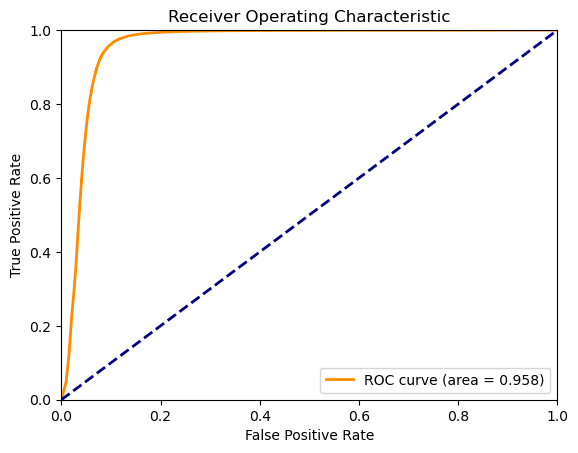

In [4]:
# Plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(df_top_1["correct"], df_top_1["score_entropy"])
roc_auc = metrics.auc(fpr, tpr)
print(f"ROC AUC: {roc_auc}")

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()
